In [74]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [46]:
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

## Attempt w/ Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pandas as pd
data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']
lr = LinearRegression()
print(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))


[0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]


In [48]:
lr.fit(X,y)

LinearRegression()

In [49]:
lr_coef_table = pd.DataFrame(lr.coef_.flatten())

In [50]:
lr_coef_table = lr_coef_table
lr_coef_table

0
0  0.359684
1  0.488332
2  1.215919

In [51]:
lr_coef_table.index = list(X.columns)

In [52]:
#Return coeficients for each type of marketing spend
lr_coef_table.rename(columns={0:"Coef"})

Coef
TV       0.359684
Radio    0.488332
Banners  1.215919

In [53]:
#Return the y intercept, which is the baseline in our marketing mix model
baseline = lr.intercept_
baseline

6678.396933606161

In [54]:
#Test our lr on a single week of spend data
data.loc["2021-10-10"]

TV         11543.58
Radio       4615.35
Banners     2518.88
Sales      15904.11
Name: 2021-10-10 00:00:00, dtype: float64

In [55]:
test_week_spend = data.loc["2021-10-10"][0:3].values

In [56]:
test_week_spend

array([11543.58,  4615.35,  2518.88])

In [57]:
#Use sample week spend data to predict sales
spend_test_prediction = lr.predict(([test_week_spend]))[0]

In [58]:
#Now use our lr to attempt a prediction using this selected week's spend figure and our lr's coeficients
print(f'lr sales prediction {spend_test_prediction}')
print(f'Actual sales {data.loc["2021-10-10"][3]}')
print(f'Delta {spend_test_prediction-data.loc["2021-10-10"][3]}')

lr sales prediction 16147.015941583588
Actual sales 15904.11
Delta 242.90594158358726


In [59]:
#Next find a correlation factor using truth and predictions
correl_factor = data.loc["2021-10-10"][3]/spend_test_prediction
correl_factor

0.9849566048325976

In [60]:
sample_week = pd.DataFrame(data.loc["2021-10-10"])
sample_week["Actual Spend/Sales"] = sample_week["2021-10-10"]
sample_week.drop(sample_week.columns[0], axis=1,inplace=True)
sample_week["Coef"] = 0
sample_week["Coef"] = lr_coef_table
sample_week

Actual Spend/Sales      Coef
TV                 11543.58  0.359684
Radio               4615.35  0.488332
Banners             2518.88  1.215919
Sales              15904.11       NaN

In [61]:
#Create a baseline row that equal to y intercept with 1 for coeficient
sample_week.loc[len(sample_week.index)] = [(baseline),1]
sample_week = sample_week.rename(index={4:"Baseline"})
sample_week = sample_week.reindex(["TV","Radio","Banners","Baseline","Sales"])
sample_week

Actual Spend/Sales      Coef
TV              11543.580000  0.359684
Radio            4615.350000  0.488332
Banners          2518.880000  1.215919
Baseline         6678.396934  1.000000
Sales           15904.110000       NaN

In [62]:
#Make predictions based on our acutal spend numbers, coeficients and correlation factor
sample_week["Predicted Sales"]= sample_week["Actual Spend/Sales"]*correl_factor*sample_week["Coef"]
sample_week["Predicted Sales"][4] = sum(sample_week["Predicted Sales"][0:4])
sample_week

Actual Spend/Sales      Coef  Predicted Sales
TV              11543.580000  0.359684      4089.578199
Radio            4615.350000  0.488332      2219.920052
Banners          2518.880000  1.215919      3016.680579
Baseline         6678.396934  1.000000      6577.931169
Sales           15904.110000       NaN     15904.110000

In [63]:
#Great, our predictions were accurate!

In [64]:
weights = pd.Series(lr.coef_,index=X.columns)
#unadjusted_sales_predictions = weights

In [65]:
weights

TV         0.359684
Radio      0.488332
Banners    1.215919
dtype: float64

In [68]:
#Create a Dataframe that contains the product of weights and spend numbers, this will need to be adjusted by the correl factor
unadj_contributions = X.copy()
unadj_contributions["TV"] = unadj_contributions["TV"]*weights.TV
unadj_contributions["Radio"] = unadj_contributions["Radio"]*weights.Radio
unadj_contributions["Banners"] = unadj_contributions["Banners"]*weights.Banners
unadj_contributions["Base"] = baseline
unadj_contributions

TV        Radio      Banners         Base
Date                                                          
2018-01-07  4865.838699     0.000000     0.000000  6678.396934
2018-01-14     0.000000  2612.407764  2698.039815  6678.396934
2018-01-21     0.000000  2068.507949  2488.938173  6678.396934
2018-01-28     0.000000  1739.542785     0.000000  6678.396934
2018-02-04     0.000000     0.000000  2659.568129  6678.396934
...                 ...          ...          ...          ...
2021-10-03     0.000000     0.000000  2056.946364  6678.396934
2021-10-10  4152.038962  2253.825236  3062.754810  6678.396934
2021-10-17     0.000000  2224.920837  2333.580164  6678.396934
2021-10-24     0.000000     0.000000  2076.364595  6678.396934
2021-10-31     0.000000     0.000000  2265.634593  6678.396934

[200 rows x 4 columns]

In [89]:
adjusted_contributions = (unadj_contributions.div(unadj_contributions.sum(axis=1), axis=0).mul(y, axis=0))
adjusted_contributions

TV        Radio      Banners         Base
Date                                                          
2018-01-07  4122.137734     0.000000     0.000000  5657.662266
2018-01-14     0.000000  2886.169485  2980.775165  7378.245350
2018-01-21     0.000000  2213.360195  2663.232057  7146.067747
2018-01-28     0.000000  1828.196513     0.000000  7018.753487
2018-02-04     0.000000     0.000000  2790.326902  7006.743098
...                 ...          ...          ...          ...
2021-10-03     0.000000     0.000000  2126.370391  6903.799609
2021-10-10  4089.578199  2219.920052  3016.680579  6577.931169
2021-10-17     0.000000  2542.196612  2666.350859  7630.742529
2021-10-24     0.000000     0.000000  2149.576162  6913.873838
2021-10-31     0.000000     0.000000  1836.568502  5413.641498

[200 rows x 4 columns]

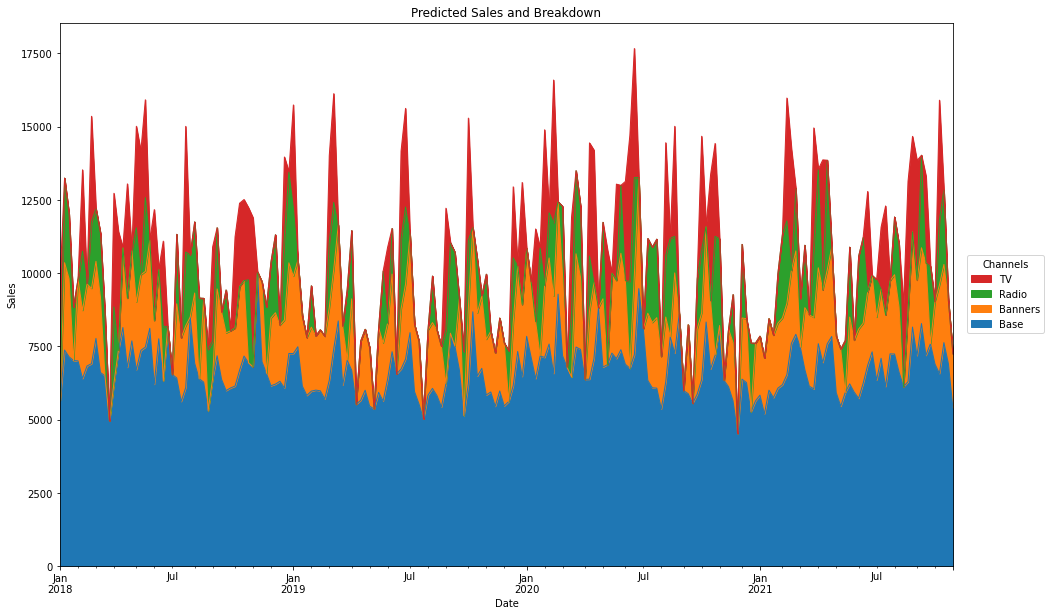

In [106]:
ax = (adjusted_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
);

In [116]:
roi = {'TV':[],'Radio':[],'Banners':[]}
for channel in roi:
    roi[channel] = adjusted_contributions[channel].sum()/data[channel].sum()
roi

{'TV': 0.3602450071355311,
 'Radio': 0.4894958936930811,
 'Banners': 1.2147284836194048}